## Example of Thinker-Augmented MDP

This notebook serves as an example of how to use the Thinker-augmented MDP with an actor-critic network. It can also be used to see how a trained agent acts in the augmented MDP.

We first initialize the environment and the actor-critic network here.

In [3]:
from thinker.main import Env
from thinker.util import init_env_out
from thinker.actor_net import ActorNet
import thinker.util as util
import matplotlib.pyplot as plt
import os
import torch

name = "Sokoban-v0" # name of the environment
wrapper_type = 2 # wrapper type; 0 for Thinker-augmented env, 1 for raw env, 2 for Thinker-augmented env with perfect model
xpid = None # or set it to the xpid of an existing run
gpu = False # whether to use gpu
savedir = "../logs/thinker" # save directory
env_n = 8 # batch size of the env
seed = 1 # seed

ckp = xpid is not None
savedir = util.full_path(savedir)

extra_params = {
    "name": name,
    "wrapper_type": wrapper_type, 
    "rec_t": 10, # add any extra argument here if needed, e.g. rec_t (number of imagainary steps)
}
if ckp:
    ckpdir = os.path.join(savedir, xpid)      
    if os.path.islink(ckpdir): ckpdir = os.readlink(ckpdir)  
    ckpdir =  os.path.abspath(os.path.expanduser(ckpdir))
    extra_params = {}

flags = util.create_setting(
    args=[], 
    savedir=savedir, 
    xpid=xpid, 
    ckp=ckp, 
    save_flags=False, 
    train_model=False,    
    parallel=False, 
    base_seed=seed,    
    env_n=env_n,  
    **extra_params
)

# create a Thinker-augmented environment
flags.return_x = True # these flags are automatically set in create_setting; so we override them here
flags.return_h = True
flags.gpu = gpu
env = Env(**vars(flags))
device = env.device

# load actor-network
actor_net = ActorNet(
    obs_space=env.observation_space, 
    action_space=env.action_space, 
    flags=flags, 
    tree_rep_meaning=env.get_tree_rep_meaning() if wrapper_type != 1 else None
)
if xpid is not None: 
    checkpoint = torch.load(os.path.join(flags.savedir, xpid, "ckp_actor.tar"))["actor_net_state_dict"]
    actor_net.load_state_dict(checkpoint)
actor_net = actor_net.to(device)

# reset the environment and initialize the initial state for the actor
state, info = env.reset()
env_out = init_env_out(state, info, flags=flags, dim_actions=actor_net.dim_actions, tuple_action=actor_net.tuple_action)  
actor_state = actor_net.initial_state(batch_size=env.env_n, device=device)

Initializing env 0 with device cpu


Symlinked log directory: /mnt/c/Users/user/RS/thinker/logs/thinker/latest
Wrote config file to /mnt/c/Users/user/RS/thinker/logs/thinker/thinker-20240904-183704/config_c.yaml


Init. environment with obs space Box(0, 255, (3, 80, 80), uint8) and action space Discrete(5)
Model network size: 1726182


### One Step in the Environment

The following code performs one step in the environment using the output of the `actor_net`, and can be executed multiple times. The returned state should contain four types of information:

- `tree_reps`: the tree representation that contains information such as predicted rewards, values, policies, and other hints.
- `real_states`: the real state of the current stage; it is fixed for all imaginary steps.
- `xs`: the imaginative state predicted by the model.
- `hs`: the hidden state of the model.

You can substitute the `action` with a fixed action to understand how the mdp works. `info` also contains useful information, such as whether the last step is real or imagaination.

=============State=============
tree_reps torch.Size([8, 101])
real_states torch.Size([8, 3, 80, 80])
xs torch.Size([8, 3, 80, 80])
hs torch.Size([8, 128, 5, 5])
=============TreeRep============
root_action tensor([1., 0., 0., 0., 0.])
root_r tensor([0.])
root_d tensor([0.])
root_v tensor([0.])
root_policy tensor([0., 0., 0., 0., 0.])
root_qs_mean tensor([ 0.0000, -0.0100, -0.0100,  0.0000,  0.0000])
root_qs_max tensor([ 0.0000, -0.0100, -0.0100,  0.0000,  0.0000])
root_ns tensor([0.0000, 0.1000, 0.1000, 0.0000, 0.0000])
root_trail_r tensor([-0.0100])
rollout_return tensor([-0.0100])
max_rollout_return tensor([0.])
root_raw_action tensor([])
cur_action tensor([0., 1., 0., 0., 0.])
cur_r tensor([-0.0100])
cur_d tensor([0.])
cur_v tensor([0.])
cur_policy tensor([0., 0., 0., 0., 0.])
cur_qs_mean tensor([0., 0., 0., 0., 0.])
cur_qs_max tensor([0., 0., 0., 0., 0.])
cur_ns tensor([0., 0., 0., 0., 0.])
cur_raw_action tensor([])
cur_reset tensor([0.])
k tensor([0., 0., 1., 0., 0., 0., 0., 0., 

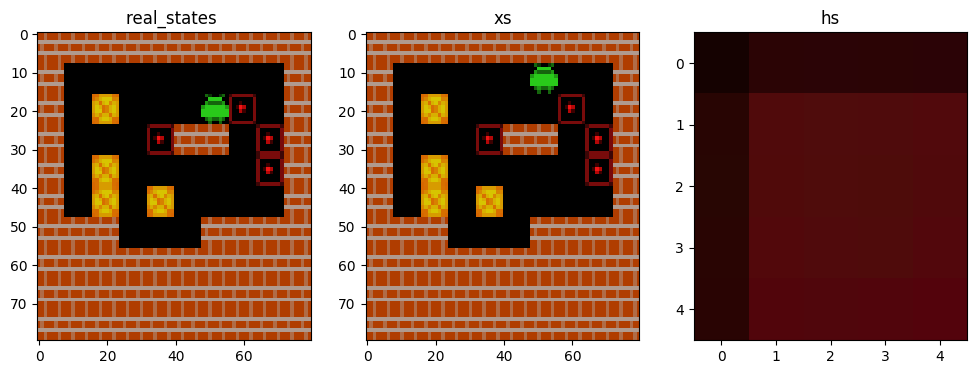

In [5]:
if env.flags.wrapper_type != 1:
    # this is for augmented env

    # one step of the actor
    actor_out, actor_state = actor_net(env_out, actor_state) 
    primary_action, reset_action = actor_out.action
    # for random action, use:
    # primary_action = torch.tensor(env.action_space[0].sample(), device=device)
    # reset_action = torch.tensor(env.action_space[1].sample(), device=device)
    # for fixed action, use:
    # primary_action = torch.full((env.env_n,), 3, dtype=torch.long, device=device)
    # reset_action = torch.full((env.env_n,), 0, dtype=torch.long, device=device)    
    action = (primary_action, reset_action)
    # one step of the environment
    state, reward, done, truncated_done, info = env.step(*action)
    # process all output from env into a named tuple for actor to process in the next step
    env_out = util.create_env_out(action, state, reward, done, truncated_done, info, flags) 

else:
    # this is for raw env
    actor_out, actor_state = actor_net(env_out, actor_state) 
    state, reward, done, truncated_done, info = env.step(actor_out.action)
    env_out = util.create_env_out(actor_out.action, state, reward, done, truncated_done, info, flags) 

print("=============State=============")
for key, value in state.items():
    print(key, value.shape if value is not None else "None")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
util.plot_raw_state(state["real_states"][0], ax=axes[0], title="real_states ")
if "xs" in state: util.plot_raw_state(state["xs"][0], ax=axes[1], title="xs")
if "hs" in state: util.plot_raw_state(state["hs"][0], ax=axes[2], title="hs")
if "tree_reps" in state:
    decoded_tree_rep = env.decode_tree_reps(state["tree_reps"])
    print("=============TreeRep============")
    for key, value in decoded_tree_rep.items():
        print(key, value[0])
